In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
from matplotlib.colors import ListedColormap
from tqdm import tqdm

In [2]:
import rasterio
from rasterio.transform import Affine
from torchvision.transforms import ToTensor
from sklearn.neighbors import KernelDensity
# 24sec

In [3]:
file_name = 'WorldPop2015/WorldPop2015.tif'

In [4]:
with rasterio.open(file_name) as image:
    image_array = image.read()
# 30 sec
# 50 sec 

In [5]:
torch_image = ToTensor()(image_array)
print(torch_image.shape)
# for night light map : [43200, 1, 17406]
# for population map : [43202, 1, 21384]
# 60 sec
# 1 min 15sec


torch.Size([43202, 1, 21384])


In [6]:
# ------------------------------------imag is defined here!!!------------------------------------
imag = torch_image.permute(1,2,0).numpy()[0]

In [7]:
imag.shape

(21384, 43202)

In [8]:
def normalise(imag):
    exclude_zero = imag != 0.0
    imag = imag[exclude_zero]
    min = np.min(imag)
    max = np.max(imag)
    normalised_imag = (imag - min) / (max - min)
    return normalised_imag
    
normalised_imag = normalise(imag)
# 6 sec
# 40 sec
# 58 sec

0.0
1.0


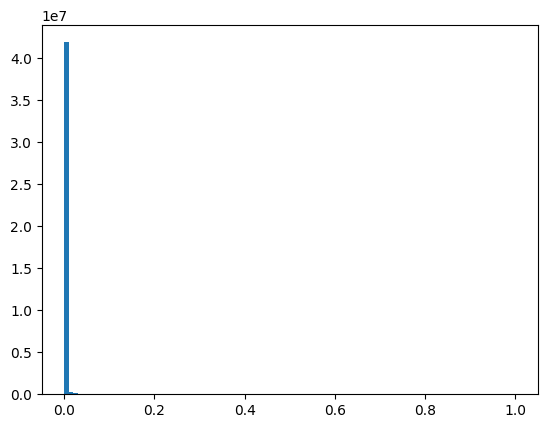

In [9]:
print(normalised_imag.min())
print(normalised_imag.max())
def plotHistNorm(imag):
    plt.hist(imag.ravel(), bins=100)
    plt.show()
plotHistNorm(normalised_imag)
# auto : 

In [10]:
def saveImgToCsv(imag, filename, lon_min=-180, lon_max=180, lat_min=-90, lat_max=+90):
    # Generate lat/lon values for each point
    latitudes = np.linspace(lat_min, lat_max, imag.shape[0])
    longitudes = np.linspace(lon_min, lon_max, imag.shape[1])

    # Create a grid of coordinates
    lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

    # Flatten the arrays to create columns
    lat_flat = lat_grid.flatten()
    lon_flat = lon_grid.flatten()
    value_flat = np.ma.filled(imag.flatten(), np.nan)  # Convert masked values to NaN

    # Create a DataFrame from the flattened arrays
    data = {
        'Latitude': lat_flat,
        'Longitude': lon_flat,
        'Value': value_flat
    }

    df = pd.DataFrame(data)

    df_clean = df.dropna()
    df_clean.to_csv(filename, index=False)
    # np.savetxt(filename, imag, delimiter=",")


# saveImgToCsv(imag, 'World.csv')
# 12 min 1.2GB
# 15 min 1.44GB
# 18 min 1.76GB
# 21 min 2.12GB
# 28 min 2.88GB
# 


In [11]:
# saveImgToCsv(imag, 'World.csv')
# 12 min 1.2GB
# 

In [12]:
def toCsvToImag(filename, lon_min=-180, lon_max=180, lat_min=-90, lat_max=+90):
    df = pd.read_csv(filename)
    lon_step = 360 / 43200
    lat_step = 180 / 17406
    latitudes = np.arange(lat_min, lat_max, lat_step)
    longitudes = np.arange(lon_min, lon_max, lon_step)
    imag = np.zeros((len(latitudes), len(longitudes)))
    for i in range(len(df)):
        lat = df['Latitude'][i]
        lon = df['Longitude'][i]
        value = df['Value'][i]
        lat_index = np.where(latitudes == lat)
        lon_index = np.where(longitudes == lon)
        imag[lat_index, lon_index] = value
    return imag
# World = toCsvToImag('World.csv')

In [13]:
#plt.imshow(np.log(imag[:17406/2, :17406/2]))

In [14]:
# plt.imshow(np.log(imag))
# plt.colorbar()
# 1 min

In [15]:
def getTransform(file_name):
    with rasterio.open(file_name) as image:
        # Extract the transformation and use it to compute the geographical coordinates
        transform = image.transform
    return transform
transform = getTransform(file_name)

In [16]:
def get_log_imag(imag, transform, lon_min = -180, lat_min = -90, lon_max = 180, lat_max = 90):
    inv_transform = ~transform
    x_pixels_min, y_pixels_min = inv_transform * (lon_min, lat_max)
    x_pixels_max, y_pixels_max = inv_transform * (lon_max, lat_min)

    # Round and convert to integer
    x_pixels_min, y_pixels_min = int(np.floor(x_pixels_min)), int(np.floor(y_pixels_min))
    x_pixels_max, y_pixels_max = int(np.ceil(x_pixels_max)), int(np.ceil(y_pixels_max))

    # Ensure the slicing indices are within the image bounds
    x_pixels_min, y_pixels_min = max(x_pixels_min, 0), max(y_pixels_min, 0)
    x_pixels_max, y_pixels_max = min(x_pixels_max, imag.shape[1]), min(y_pixels_max, imag.shape[0])

    # Log transformation
    imag_log = np.log(imag[y_pixels_min:y_pixels_max, x_pixels_min:x_pixels_max])
    imag_log = np.ma.masked_invalid(imag_log)
    boundary = np.array([lon_min, lon_max, lat_min, lat_max])
    return imag_log, boundary

World, bWorld = get_log_imag(imag, transform)
Europe, bEurope = get_log_imag(imag, transform, -25, 35, 45, 70)
Africa, bAfrica = get_log_imag(imag, transform, -25, -35, 45, 35)
South_America, bSouth_America = get_log_imag(imag, transform, -90, -60, -30, 15)
North_America, bNorth_America = get_log_imag(imag, transform, -180, 15, -30, 90)
Australia, bAustralia = get_log_imag(imag, transform, 110, -45, 160, -10)
Asia, bAsia = get_log_imag(imag, transform, 40, 0, 180, 70)
    

/var/folders/5g/9cr0t2sj5mj8w4wcjj4by3300000gq/T/ipykernel_60610/496434615.py:15: RuntimeWarning: divide by zero encountered in log
  imag_log = np.log(imag[y_pixels_min:y_pixels_max, x_pixels_min:x_pixels_max])


In [17]:
def plotlogimag(imag_log, boundary, title):
    lon_min = boundary[0]
    lon_max = boundary[1]
    lat_min = boundary[2]
    lat_max = boundary[3]

    # Plot the data with geographic coordinates
    fig, ax = plt.subplots(figsize=(20, 11), dpi = 200)
    cax = ax.imshow(imag_log, extent=[lon_min, lon_max, lat_min, lat_max], origin='upper', cmap = 'jet')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Artificial Sky Brightness of {title}')
    ax.set_xticks(np.arange(lon_min, lon_max, 10))
    ax.set_yticks(np.arange(lat_min, lat_max, 10))
    ax.grid()
    fig.colorbar(cax, ax=ax, label='Log Brightness')
    fig.savefig('WorldPop2015/'+title, dpi = 200)
plotlogimag(World, bWorld, 'the World')
plotlogimag(Europe, bEurope, 'Europe')
plotlogimag(Africa, bAfrica, 'Africa')
plotlogimag(South_America, bSouth_America, 'South America')
plotlogimag(North_America, bNorth_America, 'North America')
plotlogimag(Australia, bAustralia, 'Australia')
plotlogimag(Asia, bAsia, 'Asia')

# 

KeyboardInterrupt: 

In [ ]:
def get_H(data_log):
    std = np.std(data_log)
    N = data_log.shape[0] * data_log.shape[1]
    H = 1.06 * std * N ** (-1/5)
    return H
h = get_H(World)

In [ ]:
# def Epinechkov_kernel(x, y):
#     """
#     Compute the Epinechnikov kernel for a pair of points x and y
#     """
#     # Compute the distance between the points
#     d = np.sqrt((x[0] - y[0])**2 + (x[1] - y[1])**2)
#     # Compute the kernel
#     if d < h:
#         return 3/4 * (1 - d**2 / h**2)
#     else:
#         return 0

In [ ]:
# def Gaussian_kernel(x, y, sigma=1):
#     """
#     Compute the Gaussian kernel for a pair of points x and y
#     """
#     # Compute the distance between the points
#     d = np.sqrt((x[0] - y[0])**2 + (x[1] - y[1])**2)
#     # Compute the kernel
#     return np.exp(-d**2 / (2 * sigma**2))

In [ ]:
def KDEcore(data):
    kde = KernelDensity(bandwidth = h, kernel='epanechnikov')
    kde.fit(data)
    
    
    
    longitudes = np.linspace(-180, 180, 43200)
    latitudes = np.linspace(-90, 90, 17406)


# print(imag[2000:2024])

[[4.2614938e-05 4.2823671e-05 4.3040294e-05 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [3.9259321e-05 3.9470444e-05 3.9689068e-05 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [3.5898120e-05 3.6049503e-05 3.6437134e-05 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]


In [ ]:
def twoDimensionalEpanechnikovKDE(data):
    X = data[['lon', 'lat']].values
    kde = KernelDensity(bandwidth=0.01, kernel='epanechnikov')
    kde.fit(X)
    longitudes = np.linspace(data['lon'].min(), data['lon'].max(), 100)
    latitudes = np.linspace(data['lat'].min(), data['lat'].max(), 100)
    total_area = (longitudes.max() - longitudes.min()) * (latitudes.max() - latitudes.min())

    X_grid, Y_grid = np.meshgrid(longitudes, latitudes)
    grid_points = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T

    # Calculate the log density (log PDF) values for the grid
    log_pdf_values = kde.score_samples(grid_points)
    PDF_values = np.exp(log_pdf_values).reshape(X_grid.shape)

    fig, ax = plt.subplots(figsize=(12, 9))
    contourf_plot = ax.contourf(X_grid, Y_grid, PDF_values, cmap = 'cool')
#     ax.scatter(data['lon'], data['lat'], s=5, color = COLOUR[2], alpha=0.5, label='Crash Incidents')
    fig.colorbar(contourf_plot, ax=ax, label='KDE Value')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Map of Epanechnikov KDE')

    ## box volume proportion
    box_longitude = np.array([-78.76, -78.72])
    box_latitude = np.array([35.74, 35.78])
    box_area = (box_longitude[1] - box_longitude[0]) * (box_latitude[1] - box_latitude[0])
    
    # plot
    ax.plot([box_longitude[0], box_longitude[1], box_longitude[1], box_longitude[0], box_longitude[0]], 
            [box_latitude[0], box_latitude[0], box_latitude[1], box_latitude[1], box_latitude[0]], 
            color=COLOUR[2], linestyle='--', label='Region of Interest')
    proportion = getProportion(PDF_values, longitudes, latitudes, box_longitude, box_latitude)
    print(f"Proportion of the region within the total area: {proportion:.4f}")
    ax.legend()

    # Add text to the plot
    d = {'prob. proportion[box/total]': f'{proportion:.2%}', 
         'area proportion[box/total]': f'{box_area / total_area:.2%}',
         'PDF total(normalisation)' : f'{normalisation(PDF_values, longitudes, latitudes):.4f}',
         'max PDF value' : f'{PDF_values.max():.4f}',
         }
    add_text_to_ax(0.05, 0.30, nice_string_output(d), ax, fontsize=12)


    fig_mag, ax_mag = plt.subplots(figsize=(12, 9))
    contourf_plot_mag = ax_mag.contourf(X_grid, Y_grid, PDF_values, cmap = 'cool')
    fig_mag.colorbar(contourf_plot_mag, ax=ax_mag, label='KDE Value')
    ax_mag.scatter(data['lon'], data['lat'], s=5, color = COLOUR[1], alpha=0.5, label='Crash Incidents')
    ax_mag.set_xlabel('Longitude')
    ax_mag.set_ylabel('Latitude')
    ax_mag.set_title('Map of Epanechnikov KDE(magnified)')
    ax_mag.set_xlim(-78.9, -78.7)
    ax_mag.set_ylim(35.725, 35.825)
    ax_mag.plot([box_longitude[0], box_longitude[1], box_longitude[1], box_longitude[0], box_longitude[0]], 
            [box_latitude[0], box_latitude[0], box_latitude[1], box_latitude[1], box_latitude[0]], 
            color=COLOUR[2], linestyle='--', label='Region of Interest')
    ax_mag.legend(loc = 'upper right')
    add_text_to_ax(0.05, 0.32, nice_string_output(d), ax_mag, fontsize=12)
    
twoDimensionalEpanechnikovKDE(data)